In [31]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [19]:
import pandas as pd
import numpy as np
import nltk
import string
nltk.download('punkt')
# text preprocessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
import re, sys, os, csv

# plots and metrics

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Defining vector space dimension and fixed input size

In [20]:
# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 5

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words)
max_seq_len = 500

class_names = ['joy', 'fear', 'anger', 'sadness', 'neutral']

Importing our training and testing datasets

In [21]:
data_train = pd.read_csv('data_train.csv', encoding='utf-8')
data_test = pd.read_csv('data_test.csv', encoding='utf-8')

X_train = data_train.Text
X_test = data_test.Text
y_train = data_train.Emotion
y_test = data_test.Emotion

data = pd.concat([data_train, data_test], ignore_index=True)

In [22]:
print(data.Emotion.value_counts())
data.head(6)

Emotion
joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: count, dtype: int64


,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...
5,sadness,When my family heard that my Mother's cousin w...


data cleaning

In [23]:
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')



[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [24]:
def clean_text(data):

    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    data = re.sub(r'[^\w\s]','', data)
    data = re.sub(r'\d','',data)
    data = data.lower()

    # tokenization using nltk
    data = word_tokenize(data)
    stop_words = set(stopwords.words('english'))
    data = [word for word in data if word not in stop_words]
    stemmer = PorterStemmer()
    data = [stemmer.stem(word) for word in data]
    lemmatizer = WordNetLemmatizer()
    data = [lemmatizer.lemmatize(word) for word in data]


    return data

In [28]:
import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [29]:
texts = [' '.join(clean_text(text)) for text in data.Text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [40]:
print(texts_train[92])

bit im extrem annoy didnt phone promis would he liar


In [41]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vocab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 8830


In [ ]:


# Iterate over the text data in the column and calculate the length of each text element
max_length = 0
for text in data['Text']:
    length = len(str(text))  # Calculate the length of the text element
    if length > max_length:
        max_length = length  # Update max_length if the current length is greater

print("Maximum length of text:", max_length)

Maximum length of text: 1160


In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Fit the tokenizer on your training data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")  # adjust num_words as needed
tokenizer.fit_on_texts(texts_train)

# Convert texts to sequences
sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

# Define max sequence length (you can choose a fixed number or compute based on data)
max_seq_len = max(len(seq) for seq in sequence_train)

# Pad sequences
X_train_pad = pad_sequences(sequence_train, maxlen=max_seq_len)
X_test_pad = pad_sequences(sequence_test, maxlen=max_seq_len)


In [33]:
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

# Integer labels
y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

In [34]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

3. Import pretrained word vectors

In [35]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [36]:
import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')

    os.remove('wiki-news-300d-1M.vec.zip')

Unzipping...
done.


In [42]:
embedd_matrix = create_embedding_matrix('embeddings/wiki-news-300d-1M.vec', index_of_words, embed_num_dims)
embedd_matrix.shape

(8831, 300)

In [43]:

# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 5676
New words found: 3154


In [44]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [45]:
# Embedding layer before the actaul LSTM
input_dim = vocab_size
embedd_layer = Embedding(input_dim,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


4. Create LSTM Pipeline

In [46]:
# Parameters
lstm_output_size = 128
bidirectional = True

# Embedding Layer, LSTM or biLSTM, Dense, softmax
model1 = Sequential()
model1.add(embedd_layer)

if bidirectional:
    model1.add(Bidirectional(LSTM(units=lstm_output_size,
                              dropout=0.2,
                              recurrent_dropout=0.2)))
else:
     model1.add(LSTM(units=lstm_output_size,
                dropout=0.2,
                recurrent_dropout=0.2))

model1.add(Dense(num_classes, activation='softmax'))
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,649,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,649,300 (10.11 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,649,300 (10.11 MB)

In [47]:
# Convolution
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense,Dropout,Flatten
# Parameters
from keras.optimizers import SGD,Adam
from keras import regularizers
lstm_output_size = 128
bidirectional = True

# Embedding Layer, LSTM or biLSTM, Dense, softmax
model = Sequential()
model.add(embedd_layer)

model.add(Conv1D(200, kernel_size=3, activation = "relu"))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Flatten())
    #l2 regularizer
model.add(Dense(100,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
model.add(Dense(5, activation='softmax'))
    #sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
adam=Adam(learning_rate=0.0005,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
model.summary()
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,649,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,649,300 (10.11 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,649,300 (10.11 MB)

5. Train the Model

In [48]:
batch_size = 128
epochs = 15

hist = model.fit(X_train_pad, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.2463 - loss: 2.1607 - val_accuracy: 0.3360 - val_loss: 1.8653
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.3357 - loss: 1.8096 - val_accuracy: 0.3731 - val_loss: 1.6939
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.3908 - loss: 1.6250 - val_accuracy: 0.3817 - val_loss: 1.5964
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.4348 - loss: 1.4825 - val_accuracy: 0.4029 - val_loss: 1.5056
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.4796 - loss: 1.3440 - val_accuracy: 0.4462 - val_loss: 1.4489
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.5668 - loss: 1.1919 - val_accuracy: 0.4545 - val_loss: 1.4403
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.5997 - loss: 1.0733 - val_accuracy: 0.4595 - val_loss: 1.5304
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.6744 - loss: 0.9207 - val_accuracy: 0.4825 - val_loss

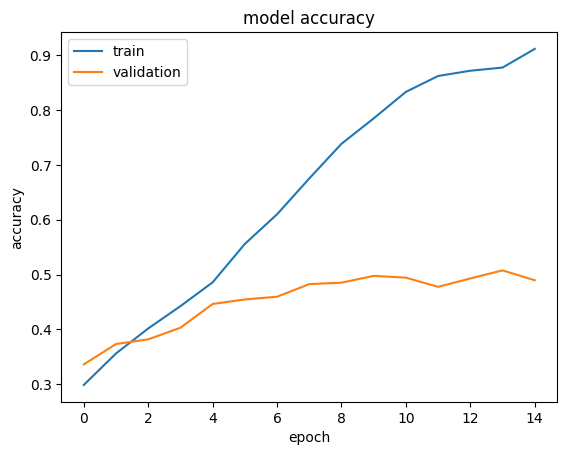

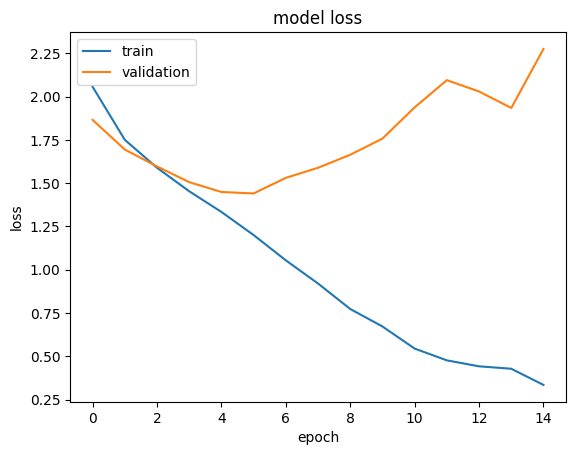

In [49]:
#  "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

6. Evaluation

In [50]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step
Accuracy: 48.95%

F1 Score: 48.95


In [51]:
#plotting confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()

    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 48.95


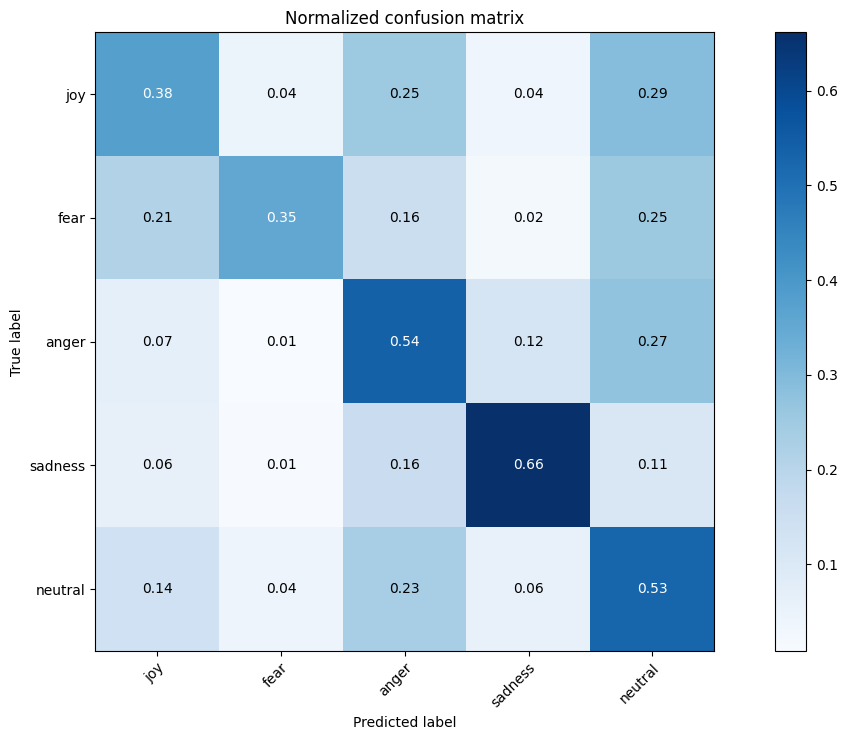

In [52]:
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(data_test.Emotion, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

Try other input

In [53]:
# creates a HDF5 file 'my_model.h5'
model.save('models/biLSTMCNN.h5')

In [54]:
from keras.models import load_model
predictor = load_model('models/biLSTMCNN.h5')

In [55]:
import time

message = ['When I meet you first time it was wonderful']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Message: ['When I meet you first time it was wonderful']
predicted: anger (0.21 seconds)
